<a href="https://colab.research.google.com/github/danchaud-vincent/tensorflow-deep-learning/blob/main/exercices-solutions/04_Transfer_Learning_with_TensorFlow_Part_1_Feature_Extraction_Exercice_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 - Transfer Learning with TensorFlow Part 1: Feature Extraction Exercice Solutions

1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction from TensorFlow Hub. How does it perform compared to our other mdoels?
2. Name 3 different image classification models on TensorFlow Hub that we haven't used.
3. Build a model to classify images of two different things you've taken photos of.
- You can use any feature extraction layer from TensorFlow Hub you like for this.
- You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.
4. What is the current best performing model on ImageNet?

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# 1. Build and fit a model using the same data `10_food_classes` but with the MobileNetV2 architecture feature extraction from TensorFlow Hub


## 1.1 Get the data

In [2]:
# download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-09-28 17:33:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 74.125.201.128, 74.125.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   202MB/s    in 0.8s    

2022-09-28 17:33:16 (202 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# extract the data inside the zip file
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [4]:
# explore the data folder
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"{dirpath} contains : {len(dirnames)} directories, {len(filenames)} files")

10_food_classes_10_percent contains : 2 directories, 0 files
10_food_classes_10_percent/test contains : 10 directories, 0 files
10_food_classes_10_percent/test/sushi contains : 0 directories, 250 files
10_food_classes_10_percent/test/chicken_wings contains : 0 directories, 250 files
10_food_classes_10_percent/test/steak contains : 0 directories, 250 files
10_food_classes_10_percent/test/hamburger contains : 0 directories, 250 files
10_food_classes_10_percent/test/chicken_curry contains : 0 directories, 250 files
10_food_classes_10_percent/test/fried_rice contains : 0 directories, 250 files
10_food_classes_10_percent/test/pizza contains : 0 directories, 250 files
10_food_classes_10_percent/test/ice_cream contains : 0 directories, 250 files
10_food_classes_10_percent/test/grilled_salmon contains : 0 directories, 250 files
10_food_classes_10_percent/test/ramen contains : 0 directories, 250 files
10_food_classes_10_percent/train contains : 10 directories, 0 files
10_food_classes_10_percent

Our training directories have 75 images per classes rather than the test directories which have 250 images per classes.

In [5]:
# Get the class names
import pathlib 

data_dir = pathlib.Path("10_food_classes_10_percent/train/")

for i in data_dir.glob("*"):
  print(i.name)

sushi
chicken_wings
steak
hamburger
chicken_curry
fried_rice
pizza
ice_cream
grilled_salmon
ramen


In [6]:
# get the class names in an array
import numpy as np
class_names = np.array(sorted([i.name for i in data_dir.glob("*")]))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

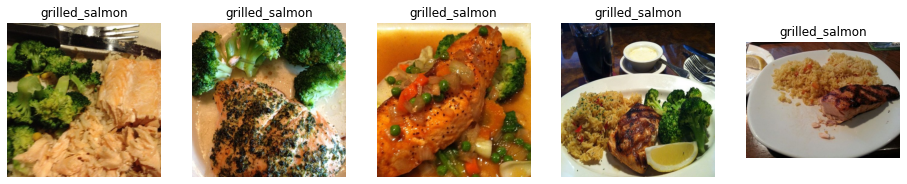

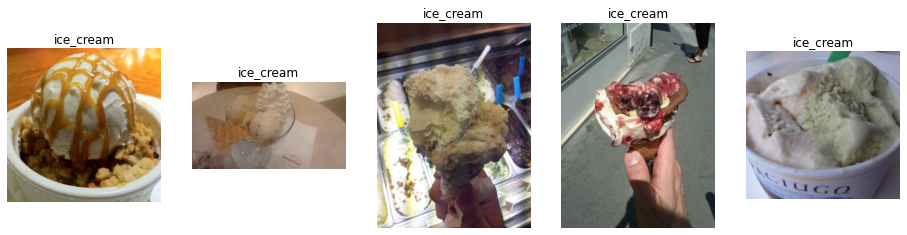

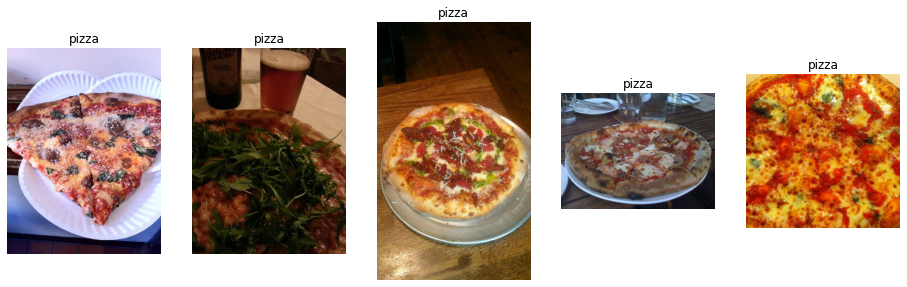

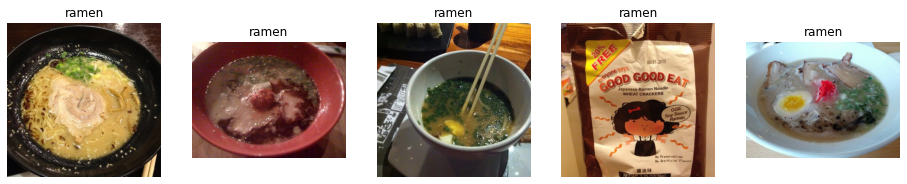

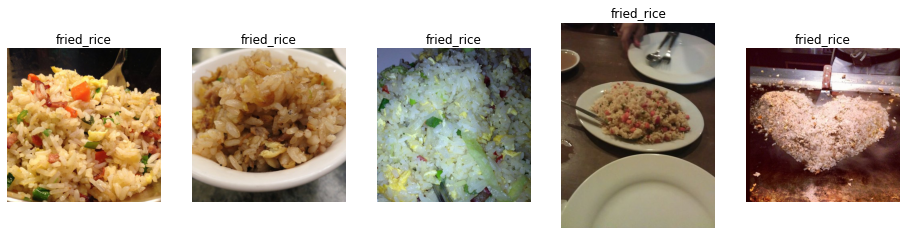

In [7]:
# visualize the data
import random
import matplotlib.image as mpimg

number_images = 5
number_classes = 5
dirname = "10_food_classes_10_percent/train/"
random_classes = random.sample(os.listdir(dirname),number_classes)

for item_class in random_classes:

  # select random images
  random_images = random.sample(os.listdir(f"{dirname}/{item_class}"),number_images)

  # create subplots
  fig, ax = plt.subplots(1,number_images,figsize=(16,8))
  
  for i in range(number_images):
    
    # read the image
    img = mpimg.imread(f"{dirname}/{item_class}/{random_images[i]}")
    
    # plot the image
    ax[i].imshow(img)
    ax[i].set_title(item_class)
    ax[i].axis('off')
  
  plt.show()

## 1.2 Preparing the data

In [8]:
# setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224,224)
BATCH_SIZE = 32

# directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# data generator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# prepare data
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


We can see we've got 750 images for the training dataset (75 per class) and 2500 images for the test dataset (250 per class)

### 1.3 Create a TensorBoard callback

The TensorBoard callback is a functionality we can add to our models to be performed during or after the training. THe TensorBoard logs the performance of multiple models and then view and compare these models in a visual board.

In [9]:
# Create a TensorBoard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):

  # path of the directory where to save the log files to be parsed by Tensorboard
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

  # tensorboard callback
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

  print(f"Saving Tensorboard log files to :{log_dir}")

  return tensorboard_callback

### 1.4 Create a model with MobilNetV2 using TensorflowHub 

In [10]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [11]:
# Mobilnet V2 feature vector
mobilnet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_075_224/classification/5"

In [12]:
def create_model(url_model, number_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it

  Arguments:
  - url_model (str): A TensorFlow Hub feature extraction URL
  - number_classes (int): Number of output neurons in the output layers, 
                          equal to the number of target classes

  Returns:
  - model : An uncompiled keras Sequential model with url_model as feature extractor layer
  and Dense output layer with number_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras Layer
  feature_extractor_layer = hub.KerasLayer(url_model,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,))

  # create the model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(number_classes, activation="softmax", name="output_layer")
  ])

  return model

In [13]:
# create the model
mobilnet_model = create_model(mobilnet_url, number_classes=train_data.num_classes)

In [14]:
# compile the model
mobilnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["accuracy"])

In [15]:
# fit the model
history_mobilnet = mobilnet_model.fit(train_data,
                                      epochs=10,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=len(test_data),
                                      callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                             experiment_name="mobilnetV2")])

Saving Tensorboard log files to :tensorflow_hub/mobilnetV2/2022-09-28_17:33:30
Epoch 1/10
24/24 [==============================] - 29s 658ms/step - loss: 2.2452 - accuracy: 0.3107 - val_loss: 1.1676 - val_accuracy: 0.6032
Epoch 2/10
24/24 [==============================] - 15s 639ms/step - loss: 0.9051 - accuracy: 0.7200 - val_loss: 0.7893 - val_accuracy: 0.7388
Epoch 3/10
24/24 [==============================] - 15s 649ms/step - loss: 0.6108 - accuracy: 0.8080 - val_loss: 0.7245 - val_accuracy: 0.7544
Epoch 4/10
24/24 [==============================] - 14s 612ms/step - loss: 0.4681 - accuracy: 0.8707 - val_loss: 0.6729 - val_accuracy: 0.7784
Epoch 5/10
24/24 [==============================] - 14s 608ms/step - loss: 0.3773 - accuracy: 0.9053 - val_loss: 0.6659 - val_accuracy: 0.7776
Epoch 6/10
24/24 [==============================] - 14s 609ms/step - loss: 0.3123 - accuracy: 0.9333 - val_loss: 0.6650 - val_accuracy: 0.7740
Epoch 7/10
24/24 [==============================] - 14s 610ms/s

### 1.5 plot the results

In [16]:
# create a dataframe
df_result = pd.DataFrame(history_mobilnet.history)
df_result

,loss,accuracy,val_loss,val_accuracy
0,2.245193,0.310667,1.167601,0.6032
1,0.905074,0.720000,0.789338,0.7388
2,0.610770,0.808000,0.724517,0.7544
3,0.468057,0.870667,0.672897,0.7784
4,0.377294,0.905333,0.665940,0.7776
5,0.312252,0.933333,0.664978,0.7740
6,0.266255,0.949333,0.657441,0.7748
7,0.223391,0.961333,0.663516,0.7744
8,0.192835,0.978667,0.666804,0.7716
9,0.168816,0.977333,0.665468,0.7712


In [17]:
def plot_loss_curves(history):
  """
  Plot the loss curves for training and validation dataset

  Arguments:
  - history : history of the trained model
  """
  # create a dataframe
  df_result = pd.DataFrame(history.history)

  # get the accuracy and losses
  loss_train = df_result["loss"]
  loss_validation = df_result["val_loss"]
  acc_train = df_result["accuracy"]
  acc_validation = df_result["val_accuracy"]

  # create subplots
  fig, ax = plt.subplots(1,2,figsize=(10,7))

  ax[0].plot(loss_train, label="loss_train")
  ax[0].plot(loss_validation, label="loss_validation")
  ax[0].set_xlabel("epochs")
  ax[0].set_title("Loss")
  ax[0].legend()

  ax[1].plot(acc_train, label="acc_train")
  ax[1].plot(acc_validation, label="acc_validation")
  ax[1].set_xlabel("epochs")
  ax[1].set_title("Accuracy")
  ax[1].legend()

  plt.show()

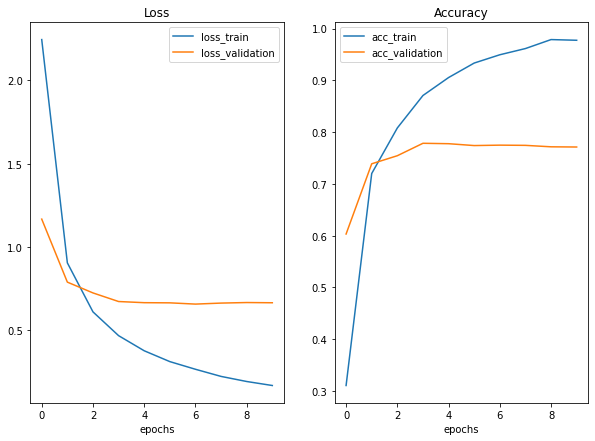

In [18]:
plot_loss_curves(history_mobilnet)

We can see our model is overfitting

## 2. Name 3 different image classification models on TensorFlow Hub that we haven't used?


- ConvNext
- Inception ResNet
- NasNEt models

## 3. Build a model to classify images of different things

### 3.1 Explore the dataset

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# import the dataset from the drive
data_dir = "/content/drive/MyDrive/MACHINE_LEARNING/DATASET"

for dirpath, dirnames, filesnames in os.walk(data_dir):
  print(f"{dirpath}, {dirnames}, files : {filesnames}")

/content/drive/MyDrive/MACHINE_LEARNING/DATASET, [], files : ['cat_vs_dog.zip', 'animals-5.zip']


In [21]:
# get the data
import zipfile

# unzip the file
zip_ref = zipfile.ZipFile(data_dir + '/' + 'animals-5.zip')
zip_ref.extractall()
zip_ref.close()

In [22]:
# explore the folder 
import os

for dirpath, dirnames, filenames in os.walk("animals-5"):
  print(f"{dirpath} : There are {len(dirnames)} directories, and {len(filenames)} files")

animals-5 : There are 2 directories, and 0 files
animals-5/test : There are 5 directories, and 0 files
animals-5/test/vache : There are 0 directories, and 100 files
animals-5/test/chien : There are 0 directories, and 100 files
animals-5/test/mouton : There are 0 directories, and 100 files
animals-5/test/elephant : There are 0 directories, and 100 files
animals-5/test/cheval : There are 0 directories, and 100 files
animals-5/train : There are 5 directories, and 0 files
animals-5/train/vache : There are 0 directories, and 130 files
animals-5/train/chien : There are 0 directories, and 130 files
animals-5/train/mouton : There are 0 directories, and 130 files
animals-5/train/elephant : There are 0 directories, and 130 files
animals-5/train/cheval : There are 0 directories, and 130 files


We have 130 images per class for the training set and 100 images per class for the test set

In [23]:
# get the classes names
import pathlib

data_dir = pathlib.Path("animals-5/train")
class_names = sorted([item.name for item in data_dir.glob("*")])
class_names

['cheval', 'chien', 'elephant', 'mouton', 'vache']

In [24]:
# visualize some pictures in the training set
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_pictures(target_folder):
  """
  Function to plot random pictures from the target folder

  Arguments:
  - target_folder (str): folder's path
  """

  for i in range(5):

    # random class
    random_class = random.sample(os.listdir(target_folder),1)[0]

    # random image
    random_image = random.sample(os.listdir(target_folder + "/" + random_class), 1)[0]
    
    # create an image readable with matplotlib
    img = mpimg.imread(f'{target_folder}/{random_class}/{random_image}')

    # figure
    plt.figure()
    plt.imshow(img)
    plt.title(random_class + "|" + str(img.shape))
    plt.show()


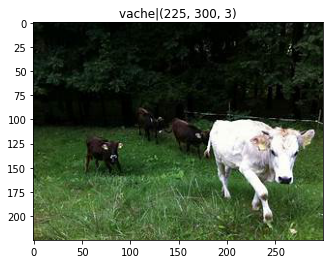

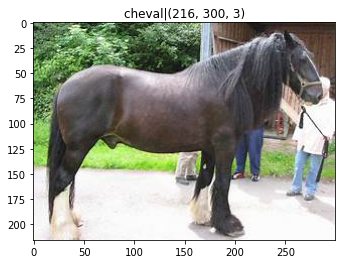

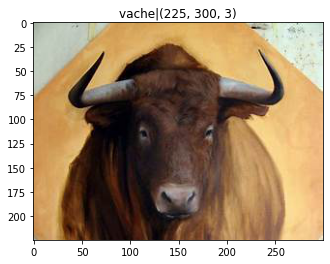

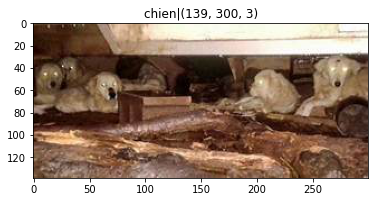

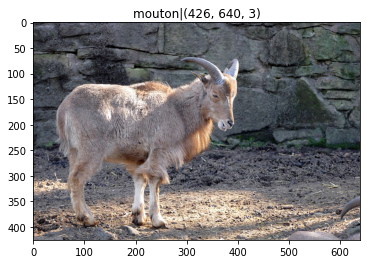

In [25]:
# visualize some picture from the training set
target_folder = "animals-5/train"

visualize_pictures(target_folder)

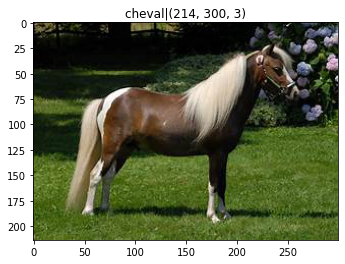

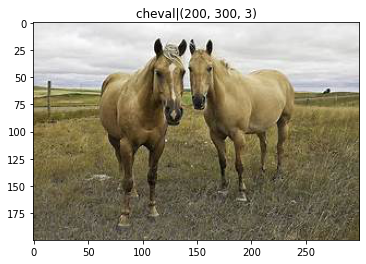

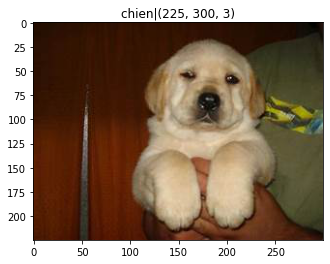

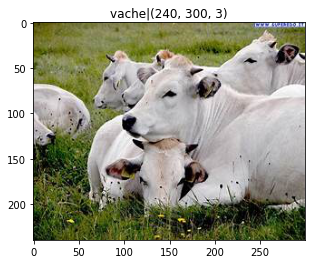

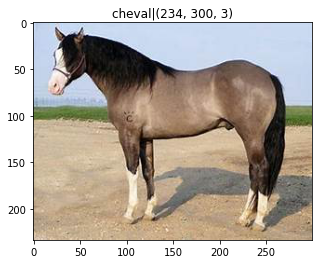

In [26]:
# visualize some pictures from the testing set
target_folder = "animals-5/test"

visualize_pictures(target_folder)

### 3.2 Build a data loader

In [27]:
# setups data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

# train and test directories
train_dir = "animals-5/train/"
test_dir = "animals-5/test/"

# data generators
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

# train and test dataset
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               class_mode="categorical",
                                               batch_size=BATCH_SIZE)

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             class_mode="categorical",
                                             batch_size=BATCH_SIZE)


Found 650 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


### 3.3 Build models with TensorFlow Hub

#### 3.3.1 ConvNext model

In [30]:
# ConvNext url
convnext_url = "https://tfhub.dev/sayakpaul/convnext_xlarge_21k_224/1"

# build a model
model_convnext = create_model(url_model=convnext_url, number_classes=len(class_names))

# compile the model


# fit the model
history_convnext = model_convnext.fit(train_data,
                                      epochs=10,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=len(test_data),
                                      callbacks=[create_tensorboard_callback("tensorflow_hub2","convnext")])

KeyboardInterrupt: ignored

5